In [690]:
import random
import time
import importlib
import game
importlib.reload(game)
from game import ColorableCliqueGame
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
print(tf.__version__)

colors = [(255,100,100), (100,100,255)]
env = ColorableCliqueGame(300,300,6,colors)
#env.close()

2.8.0


In [651]:
def draw(env : ColorableCliqueGame):
    imgdata = env.frame()
    plt.imshow(imgdata)
    #print(np.max(imgdata), np.min(imgdata), np.average(imgdata))
    plt.show()

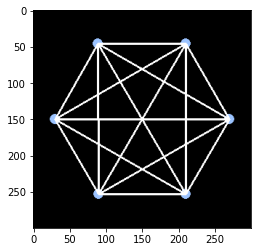

In [652]:
draw(env)

In [653]:
def checkColor(game : ColorableCliqueGame, color, nocolor, a, b, c):
    # assume (a,b) colored.
    if game.adjecencyMatrix[(a,c)] == color:
        # (a,c) also colored
        if game.adjecencyMatrix[(b,c)] == nocolor:
            # (b,c) is not colored yet.
            return 1
    elif game.adjecencyMatrix[(a,c)] == nocolor:
        # (a,c) is not colored
        if game.adjecencyMatrix[(b,c)] == color:
            # (b,c) is colored.
            return 1
    return 0

def huristics(game : ColorableCliqueGame):
    if(game.winner != -1):
        # Assume that 1 has already won, we return -(1 * 2 - 1) = -1.
        # Assume that 0 has already won, we return -(0 * 2 - 1) = 1
        score = -100 * (game.winner * 2 - 1)
        # return some value much bigger then nCr(k,3)
        return score
    # Go over all distinct triplets of vertices (a,b,c).
    # Count the number of red/blue possible triangles by adding 1 edge.
    # return the score Red - Blue.
    p0Triangles = 0
    p1Triangles = 0
    p0c = -1
    p1c = 1
    nocolor = 0
    for a in range(game.k):
        for b in range(a+1, game.k):
            for c in range(b+1, game.k):
                if game.adjecencyMatrix[(a,b)] == p0c:
                    p0Triangles += checkColor(game, p0c, nocolor, a,b,c)
                if game.adjecencyMatrix[(a,b)] == p1c:
                    p1Triangles += checkColor(game, p1c, nocolor, a,b,c)
                else:
                    # (a,b) has no color.
                    if game.adjecencyMatrix[(a,c)] == p0c and game.adjecencyMatrix[(b,c)] == p0c:
                        p0Triangles += 1
                    elif game.adjecencyMatrix[(a,c)] == p1c and game.adjecencyMatrix[(b,c)] == p1c:
                        p1Triangles += 1
    # the more triangles one can make the worse his position is.
    return p1Triangles - p0Triangles

                


In [654]:
#Searching the best move using minimax and alphabeta algorithm with negamax implementation
def alphabetaMaxDepth(cliqueGame : ColorableCliqueGame, alpha, beta, depth):
    bestscore = -99999
    if(cliqueGame.winner != -1):
        # Assume that 1 has already won, we return -(1 * 2 - 1) = -1.
        # Assume that 0 has already won, we return -(0 * 2 - 1) = 1
        score = -100 * (cliqueGame.winner * 2 - 1)
        return score
    if(depth == 0):
        return huristics(cliqueGame)
        
    curr = cliqueGame.player
    color = -(cliqueGame.player * 2 - 1)
    for move in cliqueGame.getMoves():
        cliqueGame.applyMove(move)
        # after each move the current player can only lose.
        # assume that this is the turn of player 0.
        # if after playing 0 lost. (1 won)
        # then ab(game) = -1
        # then we wish to return -1.

        # assume that this is the turn of player 1.
        # if after playing 1 lost. (0 won)
        # then ab(game) = 1
        # then we wish to return 1.

        # times 0.5, so we would prefer longer games, when we lose 100%, as the goal is to survive longer.
        if curr == cliqueGame.player:
            score = 0.975 * alphabetaMaxDepth(cliqueGame, alpha, beta, depth-1)
        else:
            score = 0.975 * alphabetaMaxDepth(cliqueGame, -beta, -alpha, depth-1)
        cliqueGame.undo()
        
        if(color * score >= beta):
            return score
        if(color * score > bestscore):
            bestscore = color * score
        if(score * color > alpha):
            alpha = score * color
    return bestscore

In [655]:
def random_move(game : ColorableCliqueGame):
    moves = game.getMoves()
    if(len(moves) > 0):
        rm = moves[int(random.random() * len(moves))]
        md = game.applyMove(rm)
        return md
    return game.applyMove(None)

In [656]:
def alphabetaMove(game : ColorableCliqueGame, depth):
    moves = game.getMoves()
    bestmove = None
    bestscore = -99999
    color = game.player * 2 - 1
    for move in moves:
        game.applyMove(move)
        score = -color * alphabetaMaxDepth(game, -99999, 99999, depth)
        game.undo()
        if score > bestscore:
            bestscore = score
            bestmove = move
    return game.applyMove(bestmove)

In [657]:
env = ColorableCliqueGame(300,300,6,colors)

[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 -1  1]
0.0


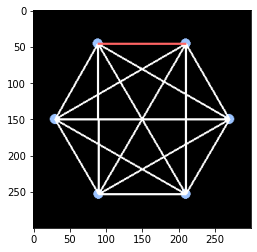

In [658]:
moves = env.getMoves()
random_move(env)
print(env.state1D())
print(alphabetaMaxDepth(env, -9999, 9999, 3))
draw(env)

In [659]:
print(alphabetaMaxDepth(env, -9999, 9999, 3))

0.0


(False, 0)
-1
-0.0


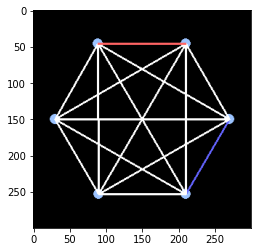

In [660]:
md = alphabetaMove(env, 3)
print(md)
print(env.winner)
print(alphabetaMaxDepth(env, -9999, 9999, 3))
draw(env)

1


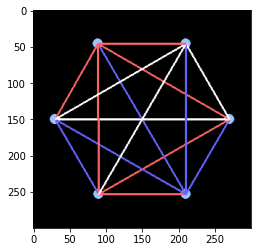

In [661]:
while(env.winner == -1):
    alphabetaMove(env,1)
print(env.winner)
draw(env)

In [662]:
#envt = ColorableCliqueGame(300,300,6,colors)
def test(test_num, random_moves, depth):
    player0Wins = 0
    player1Wins = 0
    for r in range(test_num):
        envt = ColorableCliqueGame(300,300,6,colors)
        for _ in range(random_moves):
            random_move(envt)
        #print(envt.winner)
        while(envt.winner == -1):
            #print(envt.player)
            alphabetaMove(envt, depth)
        #print(envt.winner)
        if envt.winner == 0:
            player0Wins += 1
        else:
            player1Wins += 1
        if r % 5 == 0:
            print("round ",r)
    print("player0 won :", player0Wins, "player1 won :", player1Wins)

In [663]:
test(5, 1, 99)

round  0
player0 won : 1 player1 won : 4


In [664]:
def Saved(saved, item):
    for s in saved:
        #print(s, item)
        if np.array_equal(s, item, equal_nan=True):
            return True
    return False

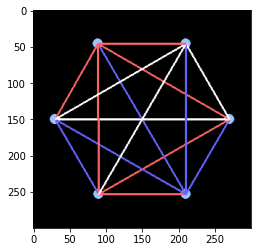

True False
6
True True
False True


In [665]:
draw(env)
c = ColorableCliqueGame(300,300,6,colors)

tm = []
tm.append(c.state1D())
print(Saved(tm, c.state1D()), Saved(tm, env.state1D()))
c.loadfrom1D(env.state1D())
tm.append(env.state1D())
print(Saved(tm, c.state1D()), Saved(tm, env.state1D()))


tm = []
tm.append(c.state1D())
c = ColorableCliqueGame(300,300,6,colors)
print(Saved(tm, c.state1D()), Saved(tm, env.state1D()))

In [666]:
def GetAllPositions(game : ColorableCliqueGame, skip_moves, depth, save : list, movesMade : list, counter):
    state = game.state1D()
    if Saved(movesMade, state):
        # print("skipped...")
        return counter
    movesMade.append(state)
    counter+=1
    if counter % 500 == 0:
        print(counter, len(save), len(movesMade))
    if game.winner != -1:
        save.append([state, alphabetaMaxDepth(game, -9999, 9999, 1)])
        return counter
    elif skip_moves <= 0:
        save.append([state, alphabetaMaxDepth(game, -9999, 9999, depth)])
    
    for move in game.getMoves():
        game.applyMove(move)
        counter = GetAllPositions(game, skip_moves-1, depth, save, movesMade, counter)
        game.undo()
        if skip_moves > 1:
            print("done...")
    return counter

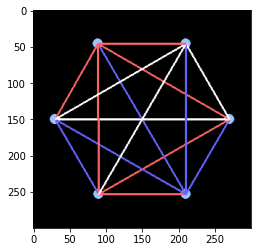

[ 1 -1  0 -1  0 -1  1  1  1  1 -1  0 -1  0 -1  1]
6


True

In [667]:
draw(env)
print(env.state1D())
c = ColorableCliqueGame(300,300,6,colors)
c.loadfrom1D(env.state1D())
np.array_equal(env.state1D(), c.state1D(), equal_nan=True)

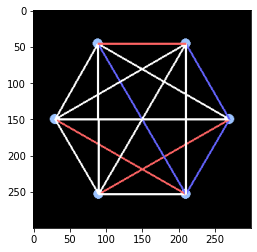

500 497 500
done...
1000 996 1000
1500 1496 1500
done...
2000 1995 2000
done...
done...
done...
2500 2492 2500
done...
done...
done...
done...
(2654, 2)


C:\Users\Michael\AppData\Local\Temp\ipykernel_23828\2075263038.py:12: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.array(arr)


In [668]:
game = ColorableCliqueGame(300,300,6,colors)
random_move(game)
random_move(game)
random_move(game)
random_move(game)
random_move(game)
random_move(game)
draw(game)
arr = []
made = []
GetAllPositions(game, 2, 2, arr, made, 0)
arr = np.array(arr)
print(arr.shape)

In [670]:
maden = np.array(made)
maden

array([[ 1, -1,  0, ...,  0, -1, -1],
       [ 1, -1, -1, ...,  0, -1,  1],
       [ 1, -1, -1, ...,  0, -1, -1],
       ...,
       [ 1, -1,  0, ..., -1, -1, -1],
       [ 1, -1,  0, ..., -1, -1, -1],
       [ 1, -1,  0, ..., -1, -1, -1]])

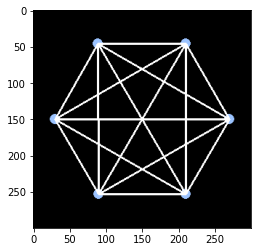

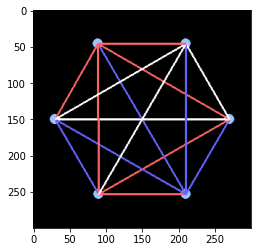

In [671]:
game = ColorableCliqueGame(300,300,6,colors)
draw(game)
draw(env)

6


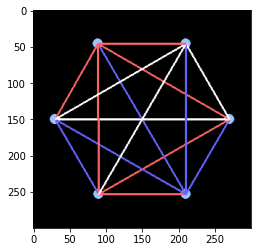

In [672]:
game = ColorableCliqueGame(300,300,6,colors)
game.loadfrom1D(env.state1D())
draw(game)

In [673]:
def nCr(n,k):
    s = n
    d = 1
    for i in range(1, k):
        s *= (n - i)
        d *= (i + 1)
    return s / d

In [675]:
arr = np.array(env.state1D())
np.count_nonzero(arr == 1) - np.count_nonzero(arr == -1)

0

In [676]:
np.zeros(int(nCr(6,2)))

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

### Get all possible positions legal and illegal

In [677]:
allp = []
size = int(nCr(6,2))
state = np.zeros(size).astype(np.int64)
counter = 0
def fill(state : np.ndarray, index):
    global counter, allp
    if index < 0:
        allp.append(state)
        return
    counter+=1
    if counter % 100 == 0:
        print(counter, index)
    for i in range(-1,2):
        ns = state.copy()
        ns[index] = i
        fill(ns, index - 1)

fill(state, size - 1)
np.array(allp).shape

100 0
200 2
300 1
400 0
500 0
600 1
700 1
800 0
900 0
1000 0
1100 0
1200 1
1300 0
1400 0
1500 0
1600 1
1700 0
1800 0
1900 2
2000 1
2100 0
2200 1
2300 0
2400 2
2500 0
2600 0
2700 0
2800 0
2900 0
3000 0
3100 0
3200 1
3300 0
3400 1
3500 0
3600 0
3700 0
3800 1
3900 1
4000 0
4100 3
4200 1
4300 0
4400 1
4500 0
4600 2
4700 0
4800 0
4900 0
5000 0
5100 0
5200 0
5300 0
5400 0
5500 0
5600 2
5700 0
5800 3
5900 0
6000 0
6100 0
6200 1
6300 2
6400 0
6500 0
6600 1
6700 0
6800 2
6900 1
7000 0
7100 0
7200 0
7300 3
7400 0
7500 0
7600 0
7700 0
7800 2
7900 0
8000 0
8100 0
8200 1
8300 0
8400 0
8500 2
8600 1
8700 0
8800 1
8900 0
9000 3
9100 0
9200 0
9300 0
9400 1
9500 2
9600 0
9700 0
9800 1
9900 0
10000 0
10100 0
10200 0
10300 0
10400 0
10500 2
10600 1
10700 0
10800 0
10900 0
11000 2
11100 0
11200 0
11300 1
11400 1
11500 0
11600 0
11700 0
11800 0
11900 0
12000 0
12100 0
12200 3
12300 1
12400 0
12500 0
12600 1
12700 1
12800 0
12900 0
13000 1
13100 0
13200 2
13300 1
13400 0
13500 0
13600 1
13700 1
13800 0
1390

(14348907, 15)

### Sort the ilegal positions, and create the tag.

In [835]:
import importlib
import game
importlib.reload(game)
from game import ColorableCliqueGame
env = ColorableCliqueGame(300,300,6,colors)

In [853]:
X = []
counter = 0
env = ColorableCliqueGame(300,300,6,colors)
for state in allp:
    #env.reset()
    counter += 1
    if counter % 500000 == 0:
        print(counter)
        #break
    if env.loadfrom1D(state):
        val = alphabetaMaxDepth(env, -9999, 9999, 3)
        #print(val)
        #print(env.winner)
        #print(alphabetaMaxDepth(env, -9999, 9999, 2))
        X.append([env.state1D(), val])
        #draw(env)
        #break
X = np.array(X)
X.shape

500000
1000000
1500000
2000000
2500000
3000000
3500000
4000000
4500000
5000000
5500000
6000000
6500000
7000000
7500000
8000000
8500000
9000000
9500000
10000000
10500000
11000000
11500000
12000000
12500000
13000000
13500000
14000000


C:\Users\Michael\AppData\Local\Temp\ipykernel_23828\1640264087.py:18: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.array(X)


(2576722, 2)

[ 1  1  1  1  1 -1  0 -1  0  0  0 -1  0 -1 -1  1] -97.5
True
-97.5
-1


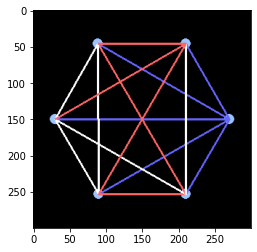

In [852]:
drawIndex = 43005
env = ColorableCliqueGame(300,300,6,colors)
print(X[drawIndex][0], X[drawIndex][1])
print(env.loadfrom1D(X[drawIndex][0]))
print(alphabetaMaxDepth(env, -9999, 9999, 3))
print(env.winner)
draw(env)

In [895]:
# def save(X, name, maxSize):
#     folds = int(X.shape[0] / maxSize)
#     for i in range(folds):
#         sn = name + "_p" + i + ".npy"
#         with open(sn, 'wb') as f:
#             np.save(f, X[i * maxSize: (i+1) * maxSize])
#save(X, "K6D3", 10000)
#import gzip

filename = 'K6D3.npz'
with open(filename, 'wb') as f:
    np.savez_compressed(f, data=X)
    #f.close()
#np.savez_compressed('/tmp/123', a=X)

In [896]:
with open('K6D3.npz', 'rb') as f:
    a = np.load(f, allow_pickle=True)
    data = a['data']

In [894]:
print(data[0])
print(X[0])

[array([ 1,  1,  1,  1,  0,  0,  0,  0, -1,  0,  0, -1, -1, -1, -1, -1],
       dtype=int64)
 -100]
[array([ 1,  1,  1,  1,  0,  0,  0,  0, -1,  0,  0, -1, -1, -1, -1, -1],
       dtype=int64)
 -100]
